# E15_LV2

In [1]:
import time
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import math
import numpy as np
import tensorflow as tf

import keras
import h5py
from pathlib import Path

import matplotlib.pyplot as plt
import cv2
import random
from tqdm import tqdm

%env SM_FRAMEWORK=tf.keras
import segmentation_models as sm
import albumentations as A

import seaborn as sns
sns.set(style='white')
sns.set_context('paper')

env: SM_FRAMEWORK=tf.keras
Segmentation Models: using `tf.keras` framework.


In [2]:
import tensorflow as tf
def init_gpu():
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            # Currently, memory growth needs to be the same across GPUs
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')

            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs\n\n")
        except RuntimeError as e:
            # Memory growth must be set before GPUs have been initialized
            print(e, "\n\n")

init_gpu()

1 Physical GPUs, 1 Logical GPUs




## Environment Setting

In [3]:
FILE_PATH = os.getenv('HOME') + '/aiffel/sia_gis/Hackerton/RSI_OP_NIA_AIHUB/LV2/LV2_PNG_DATASET.h5'      # project folder

# h5 구조 재설정
# 기본 그룹 및 데이터셋
TRAIN_BASE_DIR = "/train"
TRAIN_IMG_PATH = f'{Path(TRAIN_BASE_DIR)}/img'
TRAIN_LABEL_PATH = f'{Path(TRAIN_BASE_DIR)}/label'
# 추가 그룹 및 데이터셋
TRAIN_CROP_DIR = f'{Path(TRAIN_BASE_DIR)}/crop'  
TRAIN_CROP_IMG_PATH = f'{Path(TRAIN_BASE_DIR)}/crop/img'           
TRAIN_CROP_LABEL_PATH = f'{Path(TRAIN_BASE_DIR)}/crop/label'
# 기본 그룹 및 데이터셋
VALID_BASE_DIR = "/valid"
VALID_IMG_PATH = f'{Path(VALID_BASE_DIR)}/img'
VALID_LABEL_PATH = f'{Path(VALID_BASE_DIR)}/label'
# 추가 그룹 및 데이터셋
VALID_CROP_DIR = f'{Path(VALID_BASE_DIR)}/crop'  
VALID_CROP_IMG_PATH = f'{Path(VALID_BASE_DIR)}/crop/img'           
VALID_CROP_LABEL_PATH = f'{Path(VALID_BASE_DIR)}/crop/label' 
# 기본 그룹 및 데이터셋
TEST_BASE_DIR = "/test"
TEST_IMG_PATH = f'{Path(TEST_BASE_DIR)}/img'
TEST_LABEL_PATH = f'{Path(TEST_BASE_DIR)}/label'
# 추가 그룹 및 데이터셋
TEST_CROP_DIR = f'{Path(TEST_BASE_DIR)}/crop'  
TEST_CROP_IMG_PATH = f'{Path(TEST_BASE_DIR)}/crop/img'           
TEST_CROP_LABEL_PATH = f'{Path(TEST_BASE_DIR)}/crop/label' 

SAVE_MODEL_PATH = os.getenv('HOME') + '/aiffel/sia_gis/Hackerton/RSI_OP_NIA_AIHUB' + '/trained_models'
SAVE_LOGS_FIT_PATH = os.getenv('HOME') + '/aiffel/sia_gis/Hackerton/RSI_OP_NIA_AIHUB' + '/logs/fit'

IMAGE_SIZE = 1024
IMG_CHANNELS = 3

COLOR_MAP = [
    (165, 42, 42),   # building
    (0, 192, 0),     # road
    (255,255,255)    # background
]

* building는 COLOR_MAP[0]
* road는 COLOR_MAP[1]

## dataset 확인

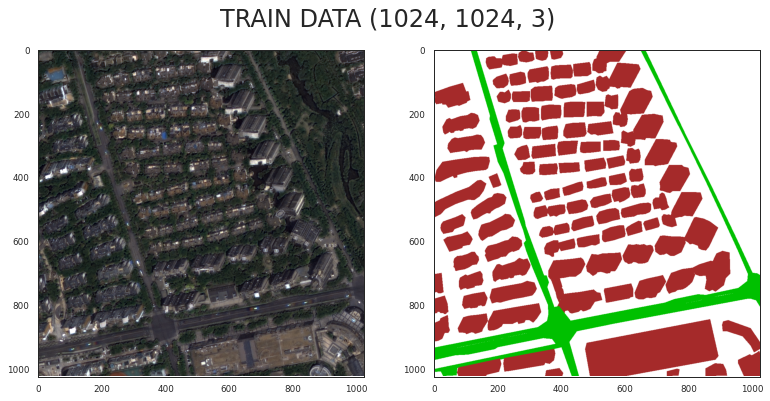

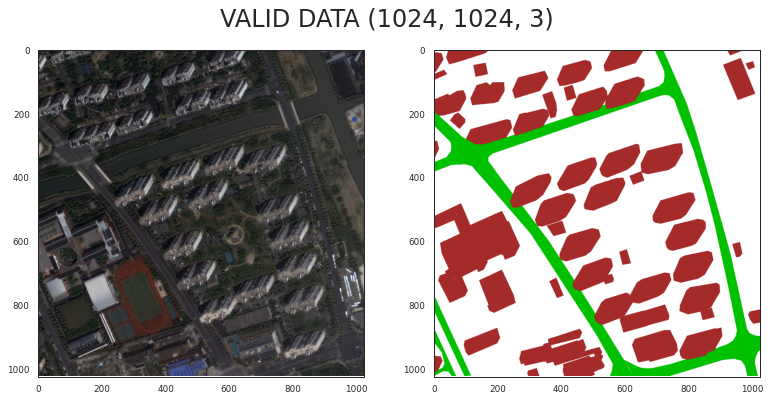

In [4]:
import matplotlib.pyplot as plt
i = 20

with h5py.File(FILE_PATH, 'r') as hdf5_file:
    plt.rc('figure', figsize=(13,6))
    plt.rc('font', size=20)

    
    plt.suptitle(f'TRAIN DATA {hdf5_file[TRAIN_IMG_PATH][i].shape}')
    plt.subplot(121)
    plt.imshow(hdf5_file[TRAIN_IMG_PATH][i][:,:,:3])
    plt.subplot(122)
    plt.imshow(hdf5_file[TRAIN_LABEL_PATH][i])
    plt.show()
    
    plt.suptitle(f'VALID DATA {hdf5_file[VALID_IMG_PATH][i].shape}')
    plt.subplot(121)
    plt.imshow(hdf5_file[VALID_IMG_PATH][i][:,:,:3])
    plt.subplot(122)
    plt.imshow(hdf5_file[VALID_LABEL_PATH][i])
    plt.show()
    

## Random crop을 위한 함수 정의

In [5]:
# LIMIT_AREA_PERCENT = 5.0
# CROP_LIMIT_AREA_PERCENT = 10.0
NCPI = 25                                 # NCPI : number of cropping per image
CROP_HEIGHT, CROP_WIDTH = 256, 256 

### get_crop_pos

In [6]:
def get_crop_pos(split_cnt, crop_type='by_stride', stride_size=192, input_size=256, img_size=1024):
    pts = []
    
    if crop_type == 'by_stride':
        for slice_pos in range(split_cnt*split_cnt):
            pos_i = int(math.floor(slice_pos / split_cnt))
            pos_j = int(slice_pos % int(split_cnt))
            
            x = stride_size * pos_i
            y = stride_size * pos_j
            
            pts.append((x, x+input_size, y, y+input_size))
            
    elif crop_type =='by_random':
        random.seed(2021)
        get_random_point = lambda: random.randint(0, img_size-input_size)   # 범위 제한
        
        for _ in range(split_cnt*split_cnt):
            x = get_random_point()
            y = get_random_point()
            pts.append((x, x+input_size, y, y+input_size))      # (x0, x1, y0, y1)
            
    return pts

### crop_png

In [7]:
def crop_png(img, pts):
    if len(img.shape) == 3:
        sub_imgs = [img[x0:x1, y0:y1, :] for x0, x1, y0, y1 in pts]
    elif len(img.shape) == 2:
        sub_imgs = [img[x0:x1, y0:y1] for x0, x1, y0, y1 in pts]
    return sub_imgs

### save_png_imgs_labels

In [8]:
def save_png_imgs_labels(dataset, i, images, labels):
    for image, label in zip(images, labels):
        dataset['img'][i, ...] = image
        dataset['label'][i, ...] = label
        i += 1
        
    return i

### area_filtering

In [9]:
def area_filtering(imgs, labels, threshold=1, img_size=256):
    """ label을 조건에 맞게 필터링해주는 함수
    라벨에서 1이 threshold 초과인 것들만을 필터링하여 반환합니다.
    하지만, threshold 미만은 모든 데이터를 지우는 것은 데이터 학습의 효율을 떨어뜨릴 수 있으므로,
    이 과정에 확률을 넣어 (면적 차지 비율)% 확률로 threshold 미만의 데이터가 필터링 되지 않도록 한다.
    
    Args:
        imgs (list): 잘려진 이미지 목록, labels와 쌍을 이룬다.
        labels (list): 잘려진 라벨 목록, imgs와 쌍을 이룬다.
        threshold (float): 라벨에 포한된 1의 비율(%)이 threshold 이하인 것은 필터링되고 초과인 것들만 남게된다.

    Returns:
        filtered_imgs (list): 필터링된 이미지
        filtered_labels (list): 필터링된 라벨
    """
    rand = lambda x: np.random.choice([0, 1], 1, p=[1-(x/100), x/100])[0]

    label_areas = [label[:,:,-1].sum() for label in labels]
#     empty_areas = np.array([img_size*img_size - area for area in label_areas])   # 빈공간 면적
    label_areas = np.array([area for area in label_areas])   # 라벨 면적
    
    rates = label_areas / (img_size * img_size) * 100
    filter_mask = [True if rate > threshold else rand(rate) for rate in rates]
    
    filtered_imgs = [img for img, mask in zip(imgs, filter_mask) if mask]
    filtered_labels = [label for label, mask in zip(labels, filter_mask) if mask]
    
    return filtered_imgs, filtered_labels

### crop_filtering_save

In [10]:
def crop_filtering_save(filtering_fun, FILE_PATH, BASE_DIR, IMG_PATH, LABEL_PATH, 
                         COLOR_MAP, img_size=256, split_cnt=5, threshold=10):
    """ label을 조건에 맞게 필터링해주는 함수
    라벨에서 1이 threshold 초과인 것들만을 필터링하여 반환합니다.
    
    Args:
        imgs (list): 잘려진 이미지 목록, labels와 쌍을 이룬다.
        labels (list): 잘려진 라벨 목록, imgs와 쌍을 이룬다.
        threshold (float)
            - 라벨에 포한된 10의 비율(%)이 threshold 이하인 것은 필터링되고 초과인 것들만 남게된다.
            - 만약 0이 주어진다면 모든 이미지를 필터링 없이 저장한다.

    Returns:
        filtered_imgs (list): 필터링된 이미지
        filtered_labels (list): 필터링된 라벨
    """
    start_time = time.time()
    with h5py.File(FILE_PATH, "a") as f:
        # create crop dataset ex. FILE[train][crop][img], FILE[train][crop][label]
        size = f[IMG_PATH].shape[0] * split_cnt*split_cnt
        if 'crop' in f[BASE_DIR].keys(): 
            del f[BASE_DIR]['crop']
            
        f[BASE_DIR].create_group('crop')
        img_ds = f[BASE_DIR]['crop'].create_dataset('img', (size, img_size, img_size, 3), np.uint8, maxshape=(size, img_size, img_size, 4))
        lable_ds = f[BASE_DIR]['crop'].create_dataset('label', (size, img_size, img_size, 3), np.float32, maxshape=(size, img_size, img_size, 3))
        
        if threshold > 0:
            pts = get_crop_pos(split_cnt, 'by_random')
        else:
            pts = get_crop_pos(split_cnt, 'by_stride')
                
        sub_idx = 0
        for i in tqdm(range(f[IMG_PATH].shape[0])):           
            # crop img with pts(left-top points)
            sub_imgs = crop_png(f[IMG_PATH][i], pts)
            
            # extract binary mask from label
            masks = [(f[LABEL_PATH][i] == v) for v in COLOR_MAP]
            mask = [(mask[:,:,0] + mask[:,:,1] + mask[:,:,2]) for mask in masks]
            mask = np.stack(mask, axis=-1).astype(np.float32)
            
             # crop mask with pts
            sub_labels = crop_png(mask, pts)
            
            # filtering labels.
            # after this, the label ratio of less than threshold is filtered out.
            filtered_imgs, filtered_labels = filtering_fun(sub_imgs, sub_labels, threshold=threshold, img_size=img_size)
            
            # save imgs and labels in split dataset
            assert len(filtered_imgs) == len(filtered_labels)
            filted_img_size = len(filtered_imgs)
            img_ds[sub_idx:sub_idx+filted_img_size, ...] = filtered_imgs
            lable_ds[sub_idx:sub_idx+filted_img_size, ...] = filtered_labels
            sub_idx += filted_img_size
            
        # resize dataset
        img_ds.resize((sub_idx, img_size, img_size, 3))
        lable_ds.resize((sub_idx, img_size, img_size, 3))
        
        print('Total # of images:', sub_idx)

* [참고: [Python numpy] np.random.choice() 메소드로 임의표본 추출하기 (무작위, 확률 샘플링)](https://rfriend.tistory.com/548)

## Dataset 추가하기

In [11]:
# train dataset
crop_filtering_save(area_filtering, 
                    FILE_PATH, TRAIN_BASE_DIR, 
                    TRAIN_IMG_PATH, TRAIN_LABEL_PATH,
                    COLOR_MAP)

100%|██████████| 1168/1168 [29:05<00:00,  1.49s/it]


Total # of images: 28965


In [12]:
# valid dataset
crop_filtering_save(area_filtering, 
                    FILE_PATH, VALID_BASE_DIR, 
                    VALID_IMG_PATH, VALID_LABEL_PATH,
                    COLOR_MAP)

100%|██████████| 128/128 [00:25<00:00,  5.05it/s]

Total # of images: 3198


In [13]:
# test dataset
crop_filtering_save(area_filtering, 
                    FILE_PATH, TEST_BASE_DIR, 
                    TEST_IMG_PATH, TEST_LABEL_PATH,
                    COLOR_MAP)

100%|██████████| 30/30 [00:04<00:00,  6.06it/s]

Total # of images: 750


## cropped dataset  확인

In [11]:
def show_n_imgs(PATH, n, x, y):
    with h5py.File(FILE_PATH, "a") as f:
        idx = 0
        imgs = f[PATH][idx*n:idx*n+n]
        plt.figure(figsize=(8, 8))
        for i, sub_img in enumerate(imgs):
            plt.subplot(x, y, i+1)
            ax = plt.gca()
            ax.axes.xaxis.set_visible(False)
            ax.axes.yaxis.set_visible(False)
            plt.imshow(sub_img[:,:,:3])

        plt.tight_layout()
        plt.show()

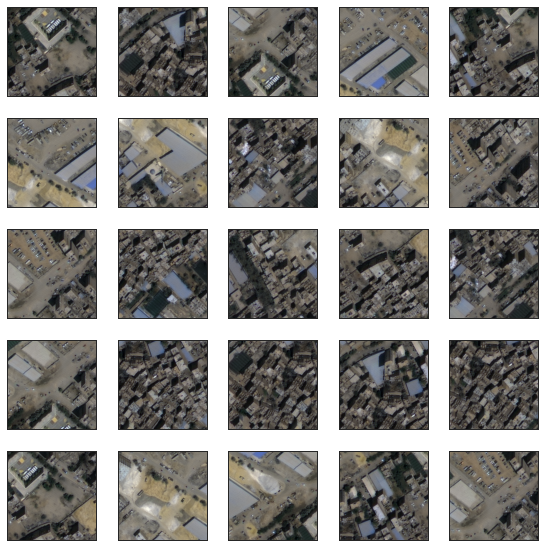

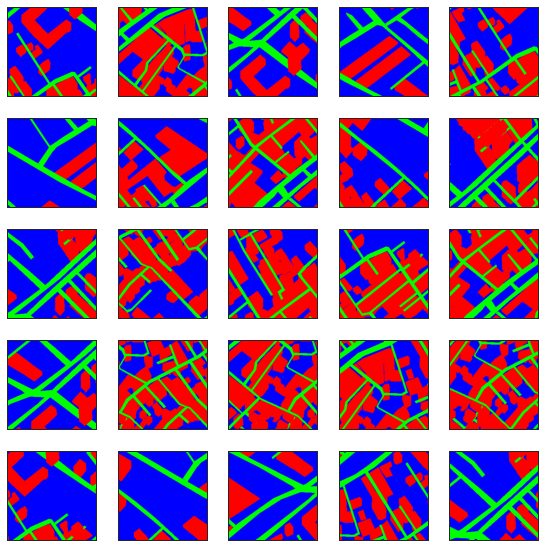

In [12]:
show_n_imgs(TRAIN_CROP_IMG_PATH, 25, 5, 5)
show_n_imgs(TRAIN_CROP_LABEL_PATH, 25, 5, 5)

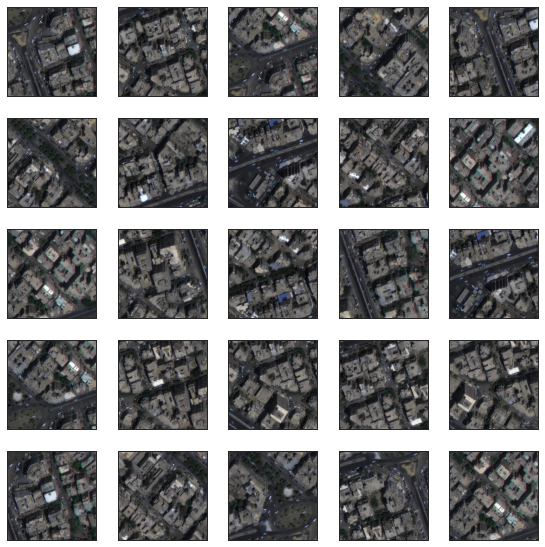

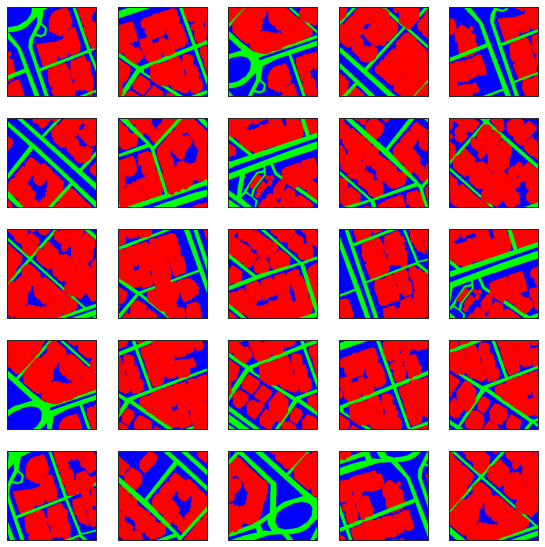

In [13]:
show_n_imgs(VALID_CROP_IMG_PATH, 25, 5, 5)
show_n_imgs(VALID_CROP_LABEL_PATH, 25, 5, 5)

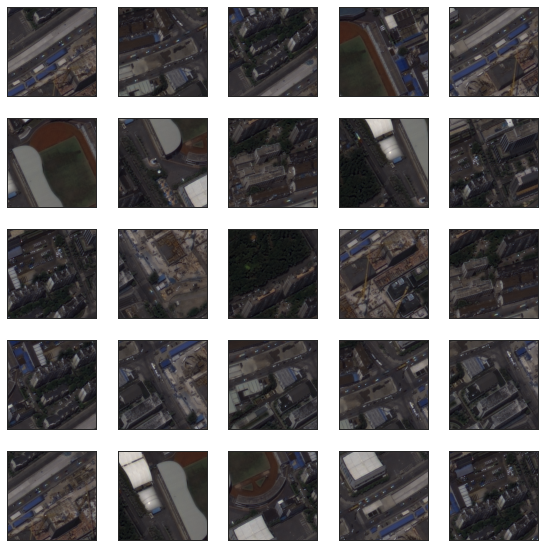

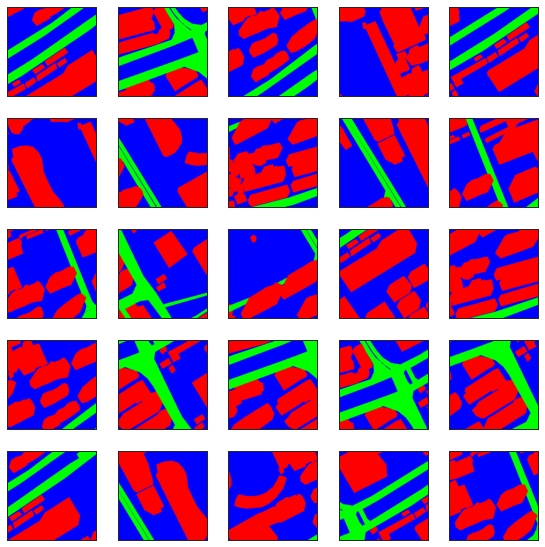

In [14]:
show_n_imgs(TEST_CROP_IMG_PATH, 25, 5, 5)
show_n_imgs(TEST_CROP_LABEL_PATH, 25, 5, 5)

## 라벨 이미지내 면적 분포확인

In [15]:
def show_area_distributaion(FILE_PATH, DIR_PATH):
    with h5py.File(FILE_PATH, "r") as f:
        img_size = f[DIR_PATH].shape[0]
        building_areas = np.sum(f[DIR_PATH], axis=1)
        building_areas = np.sum(building_areas, axis=1)

    print(f'min: {building_areas.min()}, max: {building_areas.max()}')
    plt.figure(figsize=(12,5))
    sns.histplot(building_areas, bins=100)
    plt.show()

In [16]:
def show_area_rate_distributaion(FILE_PATH, DIR_PATH):
    with h5py.File(FILE_PATH, "r") as f:
        building_areas = np.sum(f[DIR_PATH], axis=1)
        building_areas = np.sum(building_areas, axis=1)
        building_areas_rate = building_areas / (256*256) * 100
        
    print(f'min: {building_areas_rate.min()}%, max: {building_areas_rate.max()}%')
    plt.figure(figsize=(12,5))
    sns.histplot(building_areas_rate, bins=100)
    plt.show()

In [17]:
# show_area_distributaion(FILE_PATH, TRAIN_CROP_LABEL_PATH)

min: 0.0, max: 65536.0


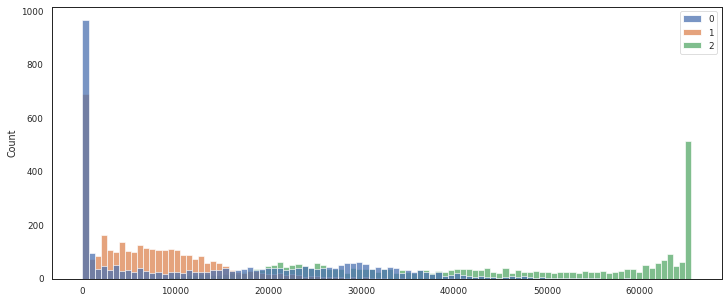

In [18]:
show_area_distributaion(FILE_PATH, VALID_CROP_LABEL_PATH)

min: 0.0, max: 65536.0


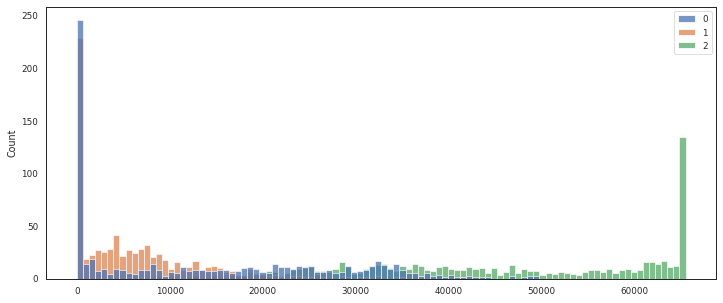

In [19]:
show_area_distributaion(FILE_PATH, TEST_CROP_LABEL_PATH)

* [참고: [matplotlib] 히스토그램](http://hleecaster.com/python-matplotlib-histogram/)

## Dataloader and utility를 위한 함수

### Utility 함수

In [20]:
def visualize(**images):
    """Plot images in one row."""
    n = len(images)
    fig, axs = plt.subplots(1, n, figsize=(10, 5))
    
    for i, (name, image) in enumerate(images.items()):
        axs[i].set_xticks([])
        axs[i].set_yticks([])
        axs[i].set_title(' '.join(name.split('_')).title())
        axs[i].imshow(image)
        
    plt.tight_layout()
    plt.show()

In [21]:
# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x

#### round(), clip(), rotation90(), CLAHE

In [22]:
def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

def get_training_augmentation():
    train_transform = [
        A.RandomRotate90(p=0.5),
        A.RandomRotate90(p=0.5),
        A.RandomRotate90(p=0.5),
        A.Lambda(mask=round_clip_0_1)
    ]
    return A.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        A.Lambda(mask=round_clip_0_1)
    ]
    return A.Compose(test_transform)

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    """
    _transform = [
        A.CLAHE(clip_limit=2.0, tile_grid_size=(16, 16), p=1),
        A.Lambda(image=preprocessing_fn),
    ]
    return A.Compose(_transform)

* [참고: albumentations - fast image augmentation library 소개 및 사용법 Tutorial](https://hoya012.github.io/blog/albumentation_tutorial/)
* [참고: albumentations example(google colab)](https://hoya012.github.io/blog/albumentation_tutorial/)

### Generator 클래스

In [23]:
class SatelliteGenerator(tf.keras.utils.Sequence):
    '''
    ref: https://github.com/AIFFEL-FREESIA/Model/blob/master/Unet_building_256_2.ipynb
    SatelliteGenerator는 tf.keras.utils.Sequence를 상속받습니다.
    '''
    def __init__(self, 
                 filepath,
                 x_path,
                 y_path,
                 batch_size=8,
                 augmentation=None, 
                 preprocessing=None,
                 is_train=True):
        
        self.filepath = filepath
        self.x_path = x_path
        self.y_path = y_path
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing

        self.size = 0
        with h5py.File(self.filepath, 'r') as f:
            self.size = f[x_path].shape[0]
            
        self.batch_size = batch_size
        self.is_train = is_train
    
    def __len__(self):
        return math.ceil(self.size / self.batch_size)

    def __getitem__(self, index):
        with h5py.File(self.filepath, 'r') as f:
            images = f[self.x_path][index*self.batch_size : (index + 1)*self.batch_size]
            masks = f[self.y_path][index*self.batch_size : (index + 1)*self.batch_size]
            res = [(img, mask) for img, mask in zip(images, masks)]

            if self.augmentation:
                res = [self.augmentation(image=img, mask=mask) for img, mask in res]
                res = [(r['image'], r['mask']) for r in res]
            if self.preprocessing:
                res = [self.preprocessing(image=img, mask=mask) for img, mask in res]
                res = [(r['image'], r['mask']) for r in res]
            
            images = np.array([img for img, _ in res ])
            masks = np.array([mask for _, mask in res ])
            
            return images, masks

    def on_epoch_end(self):
        # 한 epoch가 끝나면 실행되는 함수입니다. 학습중인 경우에 순서를 random shuffle하도록 적용한 것을 볼 수 있습니다.
        self.indexes = np.arange(self.size)
        if self.is_train == True :
            np.random.shuffle(self.indexes)
        
        return self.indexes

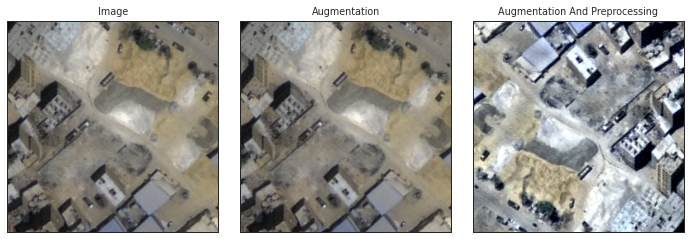

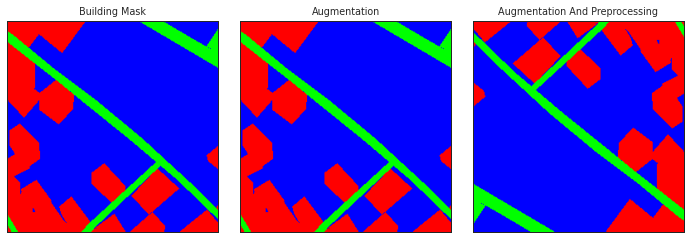

In [24]:
# Lets look at augmented data we have
dataset = SatelliteGenerator(
    FILE_PATH,
    TRAIN_CROP_IMG_PATH,
    TRAIN_CROP_LABEL_PATH, 
#     augmentation=get_training_augmentation()
)

dataset_aug = SatelliteGenerator(
    FILE_PATH,
    TRAIN_CROP_IMG_PATH,
    TRAIN_CROP_LABEL_PATH, 
    augmentation=get_training_augmentation())

preprocess_input = sm.get_preprocessing('efficientnetb3')

dataset_aug_pre = SatelliteGenerator(
    FILE_PATH,
    TRAIN_CROP_IMG_PATH,
    TRAIN_CROP_LABEL_PATH,
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocess_input)
)

idx = 1
image, mask = dataset[idx]              # get some sample
image_aug, mask_aug = dataset_aug[idx]
image_aug_pre, mask_aug_pre = dataset_aug_pre[idx]


visualize(
    image=image[0], 
    augmentation=image_aug[0],
    augmentation_and_preprocessing=denormalize(image_aug_pre[0])
)

visualize(
    building_mask=mask[0],
    augmentation=mask_aug[0],
    augmentation_and_preprocessing=mask_aug_pre[0]
)

* [참고: Segmentation models](https://segmentation-models.readthedocs.io/en/latest/tutorial.html)

## Train Model

### train을 위한 함수 정의

In [25]:
def get_datagenerator(BATCH_SIZE=8, BACKBONE='efficientnetb3'):
    # Dataset for train images
    preprocess_input = sm.get_preprocessing(BACKBONE)
    
    train_datagenerator = SatelliteGenerator(
        FILE_PATH,
        TRAIN_CROP_IMG_PATH,
        TRAIN_CROP_LABEL_PATH,
        batch_size=BATCH_SIZE,
        augmentation=get_training_augmentation(),
        preprocessing=get_preprocessing(preprocess_input),
        is_train=True
    )

    # Dataset for validation image
    valid_datagenerator = SatelliteGenerator(
        FILE_PATH,
        VALID_CROP_IMG_PATH, 
        VALID_CROP_LABEL_PATH, 
        batch_size=BATCH_SIZE,
        augmentation=get_validation_augmentation(),
        preprocessing=get_preprocessing(preprocess_input),
        is_train=False
    )

    return train_datagenerator, valid_datagenerator

In [26]:
import time
import datetime

def logging_time(original_fn):
    def wrapper_fn(*args, **kwargs):
        start_time = time.time()
        
        result = original_fn(*args, **kwargs)
        
        sec = time.time()-start_time
        times = str(datetime.timedelta(seconds=sec)).split(".")
        times = times[0]
        print(f'WorkingTime : {times}')
        
        return result
    
    return wrapper_fn

In [27]:
def get_cosine_lr(initial_learning_rate, t_period, lr_min=0.):
    return tf.keras.experimental.CosineDecay(
        initial_learning_rate=initial_learning_rate,
        decay_steps=t_period, alpha=lr_min / initial_learning_rate)

In [28]:
def get_model(model_name, optim, train, valid, MODEL_PATH, patience=10):
    BACKBONE = 'efficientnetb3'
    CLASSES = ['building', 'roads', 'background']

    # define network parameters
    n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES))  # case for binary and multiclass segmentation
    activation = 'sigmoid' if n_classes == 1 else 'softmax'

    #create model
    tf.random.set_seed(2021)
    model = sm.Unet(BACKBONE, classes=n_classes, activation=activation, encoder_weights='imagenet')

    # Segmentation models losses can be combined together by '+' and scaled by integer or float factor
    dice_loss = sm.losses.DiceLoss()
    focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
    total_loss = dice_loss + (1 * focal_loss)
    metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

    # compile keras model with defined optimozer, loss and metrics
    model.compile(optim, total_loss, metrics)
    
    log_dir = f"./logs/fit/{model_name}"
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    
    callbacks = [
        keras.callbacks.ModelCheckpoint(MODEL_PATH, save_weights_only=True, save_best_only=True, mode='min', monitor='val_loss'),
        keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                          factor=0.1, 
                                          patience=5, 
                                          verbose=1, 
                                          mode='min'),
        tensorboard_callback,
        keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=patience)
    ]
    
    return model, callbacks

* [참고:[TensorFlow] TensorBoard 사용하기](https://blog.naver.com/rhrkdfus/221580989557)

In [29]:
def show_history_plot(history):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    keys = [('loss', 'val_loss'), ('iou_score', 'val_iou_score'), ('f1-score', 'val_f1-score')]
    
    for (train, val), ax in zip(keys, axes):
        ax.plot(history[train])
        ax.plot(history[val])
        ax.set_title(f'Model {train}')
        ax.set_ylabel(train)
        ax.set_xlabel('Epoch')
        ax.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()
# show_history_plot(new_history)

## E15-3BnR

### Fit parameters setting

In [30]:
lr = 1e-3
BATCH_SIZE = 8      # for PC, 32: for cloud
EPOCHS = 100
NCPI = 25

optim = keras.optimizers.Adam(learning_rate=lr)
train_datagenerator, valid_datagenerator = get_datagenerator(BATCH_SIZE=BATCH_SIZE)

In [31]:
model_15_3BnR, callbacks = get_model('E15-3BnR',
                                  optim,
                                  train_datagenerator, 
                                  valid_datagenerator,
                                  SAVE_MODEL_PATH +'/E15_3BnR.h5',
                                  patience=10)

In [32]:
model_15_3BnR.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, None, None, 4 1080        input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, None, None, 4 160         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, None, None, 4 0           stem_bn[0][0]                    
______________________________________________________________________________________________

In [33]:
start_time = time.time()

history_15_3BnR = model_15_3BnR.fit(
    train_datagenerator, 
    steps_per_epoch=len(train_datagenerator), 
    epochs=EPOCHS, 
    callbacks=callbacks, 
    validation_data=valid_datagenerator, 
    validation_steps=len(valid_datagenerator))

sec = time.time()-start_time
times = str(datetime.timedelta(seconds=sec)).split(".")
times = times[0]
print(f'WorkingTime : {times}')

Epoch 1/100
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 

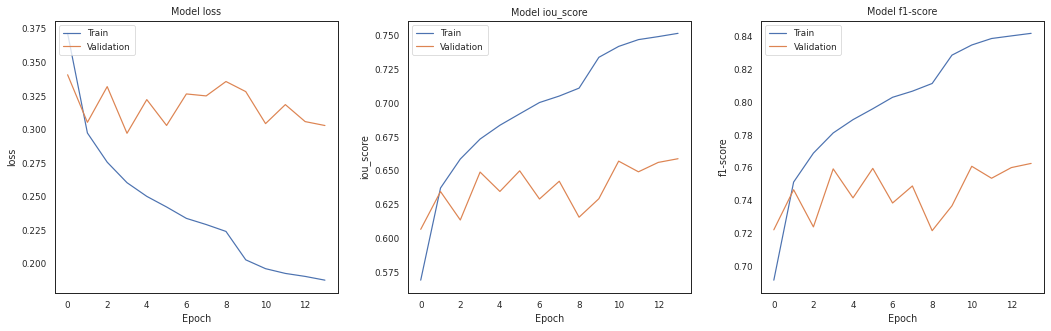

In [34]:
show_history_plot(history_15_3BnR.history)

### Slide crop한 경우에 Evaluation을 위한 함수 정의

In [35]:
IMG_SIZE = 1024
CROP_SIZE = 256
SPLIT_CNT = 5
STRIDE_SIZE = int((IMG_SIZE - CROP_SIZE)/(SPLIT_CNT - 1))
print('Stride size:', STRIDE_SIZE)

Stride size: 192


In [68]:
def merge_img(sub_imgs, pts):
    merged = np.zeros((1024, 1024, 3))        # sub_imgs를 합친 이미지
    seg_map = np.zeros((1024, 1024))          # segmentation map, (0, 1, 2) 로 구성 ; (3, 1024, 1024)
    
    for i, (x0, x1, y0, y1) in enumerate(pts):
        sub_a = merged[x0:x1, y0:y1, :]        # [[0,0,0], [0,0,0], ...]
        sub_b = sub_imgs[i]
        added = np.where(sub_a > sub_b, sub_a, sub_b)
        reduced = np.argmax(added, axis=-1)   # 0, 1, 2 channel 중 큰 것
        merged[x0:x1, y0:y1, :] = added
        seg_map[x0:x1, y0:y1] = reduced
        
    return seg_map

In [69]:
def inference(model, img, pts):
    preprocessing = A.Compose([
        A.Lambda(image=sm.get_preprocessing(BACKBONE)),
    ])
    sub_imgs = crop_png(img, pts)
    sub_imgs = [preprocessing(image=img)['img'] for img in sub_imgs]
    sub_imgs = [np.expand_dims(img, axis=0) for img in sub_imgs]
    predict_imgs = [model.predict(img) for img in sub_imgs]
    predict_imgs = [predict.squeeze() for predict in predict_imgs]
    merged_img = merge_img(predict_imgs, pts)
    
    return merged_img

In [72]:
def coloring_seg_map(seg_map): # (1024, 1024) segmentation map -> (1024, 1024, 3)
    color_map = np.stack([seg_map, seg_map, seg_map], axis=-1)
    
    color_map = np.where(color_map == 0, COLOR_MAP[0], color_map)
    color_map = np.where(color_map == 1, COLOR_MAP[1], color_map)
    color_map = np.where(color_map == 2, COLOR_MAP[2], color_map).astype(np.uint8)
    
    print(np.unique(seg_map))
    
    return color_map

#### show_inference

In [39]:
def show_inference(model, pts, first=0, last=30):
    with h5py.File(FILE_PATH, "r") as f:
        for idx in range(first, last):
            img = f[VALID_IMG_PATH][idx]
            
            predicted = inference(model, img, pts)
            
            predicted = coloring_seg_map(predicted)
            
            visualize(
                image=img[:,:,:3],
                ground_truth=f[VALID_LABEL_PATH][idx],
                predicted=predicted
            )

### Evaluation

In [40]:
model_15_3BnR.load_weights(SAVE_MODEL_PATH +'/E15_3BnR.h5')

In [42]:
preprocess_input = sm.get_preprocessing('efficientnetb3')

test_datagenerator = SatelliteGenerator(
    FILE_PATH,
    TEST_CROP_IMG_PATH, 
    TEST_CROP_LABEL_PATH, 
    batch_size=BATCH_SIZE,
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
    is_train=False
)

val_metrix = model_15_3BnR.evaluate(valid_datagenerator)
test_metrix = model_15_3BnR.evaluate(test_datagenerator)

94/94 [==============================] - 6s 59ms/step - loss: 0.3355 - iou_score: 0.6176 - f1-score: 0.7306


In [44]:
BACKBONE = 'efficientnetb3'

# split_cnt, crop_type='by_stride', stride_size=192, input_size=256, img_size=1024
crop_pts = get_crop_pos(SPLIT_CNT, STRIDE_SIZE, CROP_SIZE)

TypeError: Invalid shape (1024, 1024, 3, 3) for image data

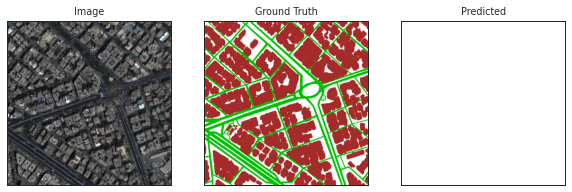

In [64]:

show_inference(model=model_15_3BnR, pts=crop_pts, first=0, last=10)

In [ ]:
show_inference(model=model_15_3BnR, pts=crop_pts, first=10, last=20)

In [ ]:
show_inference(model=model_15_3BnR, pts=crop_pts, first=20, last=30)

## E15-4BnR

### Fit parameters setting

In [54]:
lr = 1e-4
BATCH_SIZE = 8      # for PC, 32: for cloud
EPOCHS = 100
NCPI = 25

optim = keras.optimizers.Adam(learning_rate=lr)
train_datagenerator, valid_datagenerator = get_datagenerator(BATCH_SIZE=BATCH_SIZE)

In [55]:
model_15_4BnR, callbacks = get_model('E15-4BnR',
                                  optim,
                                  train_datagenerator, 
                                  valid_datagenerator,
                                  SAVE_MODEL_PATH +'/E15_4BnR.h5',
                                  patience=10)

In [56]:
start_time = time.time()

history_15_4BnR = model_15_4BnR.fit(
    train_datagenerator, 
    steps_per_epoch=len(train_datagenerator), 
    epochs=EPOCHS, 
    callbacks=callbacks, 
    validation_data=valid_datagenerator, 
    validation_steps=len(valid_datagenerator))

sec = time.time()-start_time
times = str(datetime.timedelta(seconds=sec)).split(".")
times = times[0]
print(f'WorkingTime : {times}')

Epoch 1/100
3621/3621 [==============================] - 2546s 700ms/step - loss: 0.4761 - iou_score: 0.4847 - f1-score: 0.6105 - val_loss: 0.3330 - val_iou_score: 0.6095 - val_f1-score: 0.7254
Epoch 2/100
3621/3621 [==============================] - 2534s 700ms/step - loss: 0.2905 - iou_score: 0.6460 - f1-score: 0.7585 - val_loss: 0.3044 - val_iou_score: 0.6394 - val_f1-score: 0.7496
Epoch 3/100
3621/3621 [==============================] - 2520s 696ms/step - loss: 0.2557 - iou_score: 0.6793 - f1-score: 0.7857 - val_loss: 0.2866 - val_iou_score: 0.6555 - val_f1-score: 0.7622
Epoch 4/100
3621/3621 [==============================] - 2493s 688ms/step - loss: 0.2371 - iou_score: 0.6988 - f1-score: 0.8004 - val_loss: 0.2874 - val_iou_score: 0.6531 - val_f1-score: 0.7652
Epoch 5/100
3621/3621 [==============================] - 2529s 698ms/step - loss: 0.2192 - iou_score: 0.7169 - f1-score: 0.8160 - val_loss: 0.2745 - val_iou_score: 0.6672 - val_f1-score: 0.7733
Epoch 6/100
3621/3621 [=======

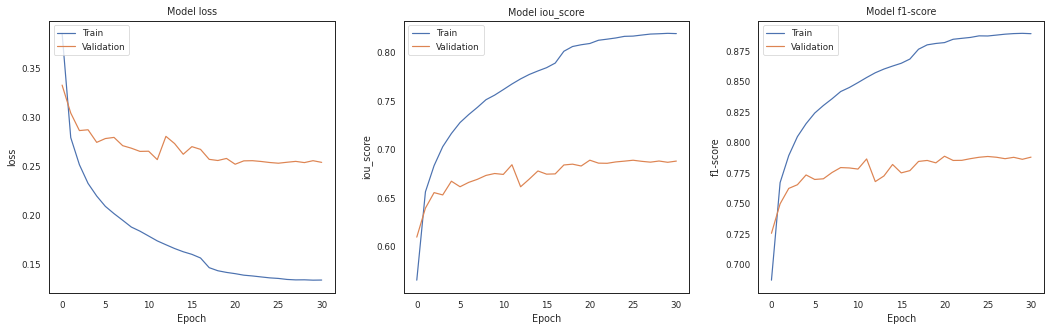

In [57]:
show_history_plot(history_15_4BnR.history)

### Evaluation

In [60]:
model_15_4BnR.load_weights(SAVE_MODEL_PATH +'/E15_4BnR.h5')

In [59]:
preprocess_input = sm.get_preprocessing('efficientnetb3')

test_datagenerator = SatelliteGenerator(
    FILE_PATH,
    TEST_CROP_IMG_PATH, 
    TEST_CROP_LABEL_PATH, 
    batch_size=BATCH_SIZE,
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
    is_train=False
)

val_metrix = model_15_4BnR.evaluate(valid_datagenerator)
test_metrix = model_15_4BnR.evaluate(test_datagenerator)

94/94 [==============================] - 6s 60ms/step - loss: 0.2806 - iou_score: 0.6649 - f1-score: 0.7709


[0.]


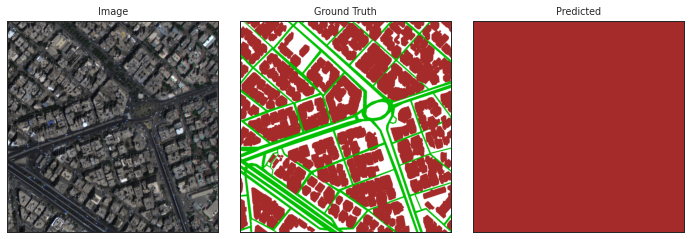

[0.]


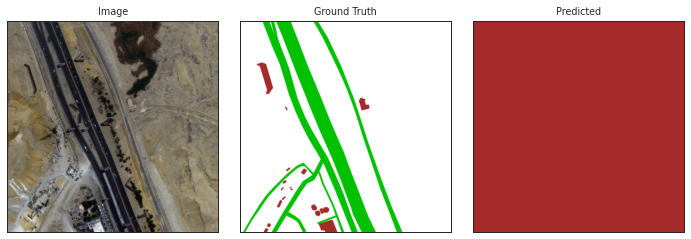

[0.]


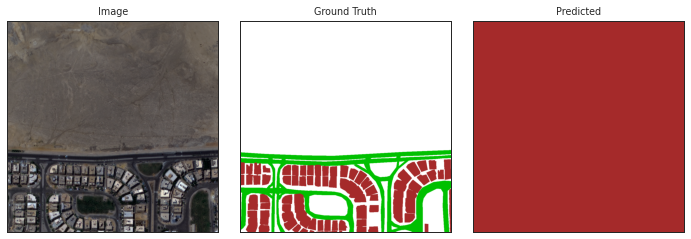

[0.]


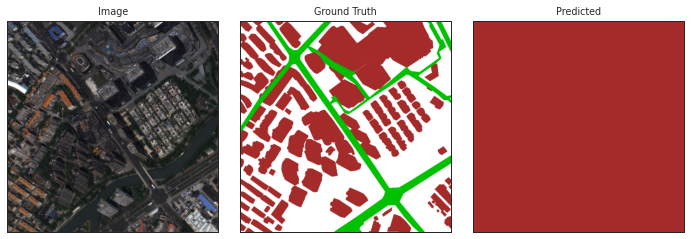

[0.]


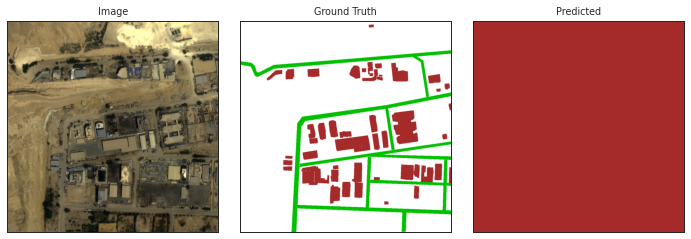

[0.]


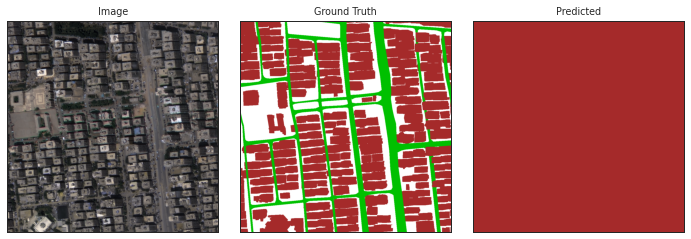

[0.]


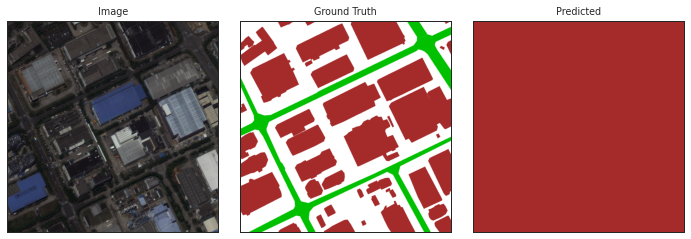

[0.]


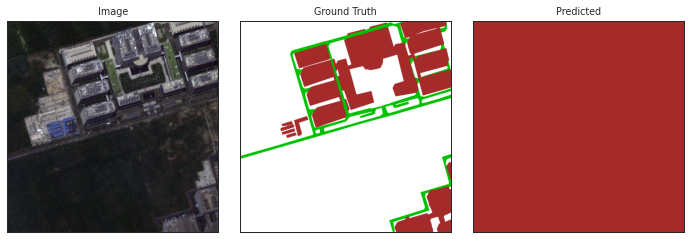

[0.]


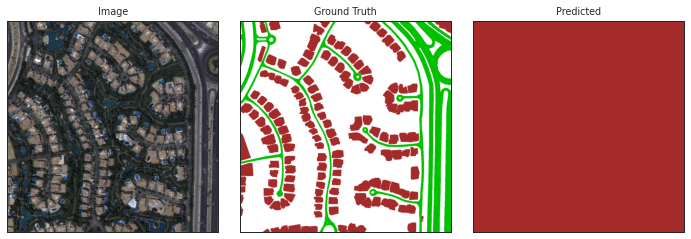

[0.]


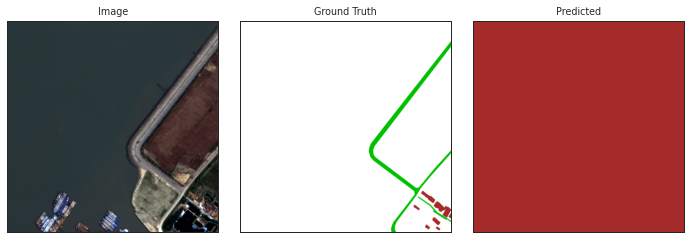

In [73]:
BACKBONE = 'efficientnetb3'

crop_pts = get_crop_pos(SPLIT_CNT, STRIDE_SIZE, CROP_SIZE)

show_inference(model=model_15_4BnR, pts=crop_pts, first=0, last=10)